In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

LABELS = ["Normal", "Fraud"]

In [2]:
data = pd.read_csv("creditcard.csv")

# Data exploration

In [3]:
data.shape

(284807, 31)

In [4]:
data.isnull().values.any()

False

In [5]:
data.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


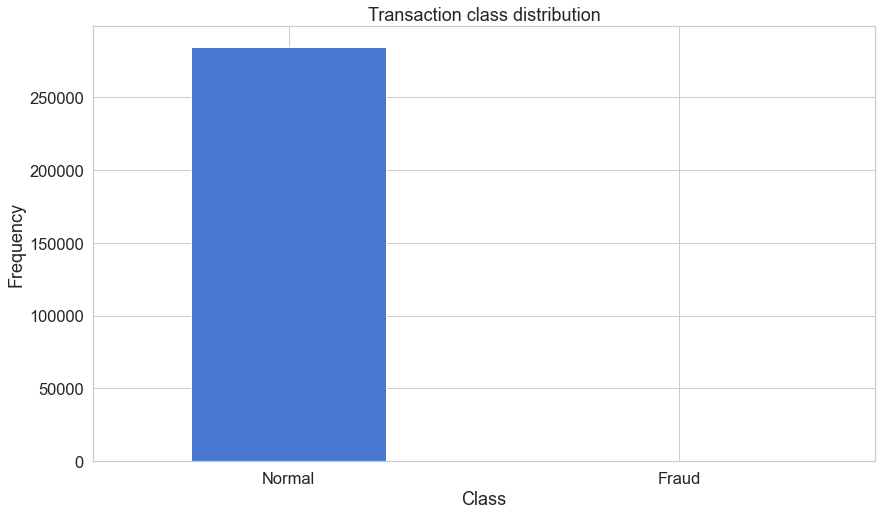

In [6]:
count_classes = pd.value_counts(data['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

In [7]:
frauds = data[data.Class == 1]
normal = data[data.Class == 0]

In [8]:
frauds.shape

(492, 31)

In [9]:
normal.shape

(284315, 31)

In [10]:
frauds.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [11]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

## Graphical representation

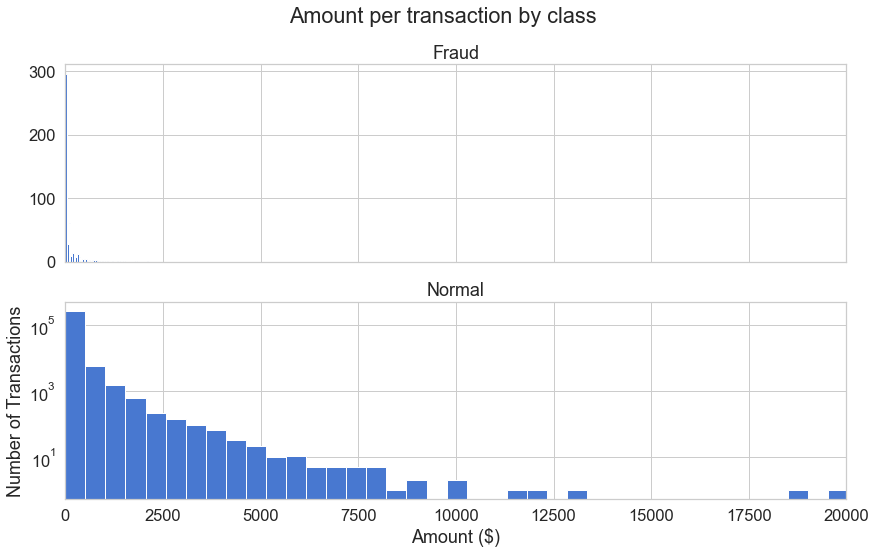

In [12]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

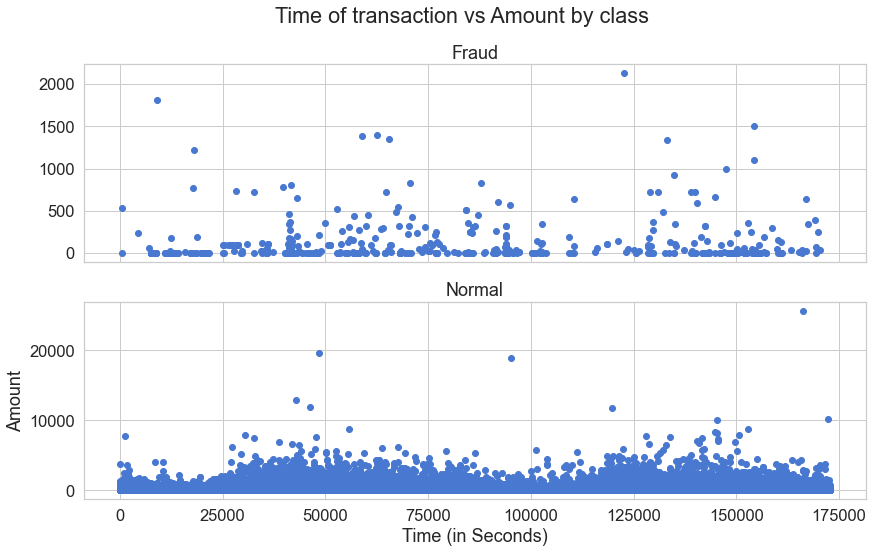

In [13]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

# Data preparation

In [14]:
data = data.drop(['Time'], axis=1)

data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

## Data split

In [15]:
RANDOM_SEED = 42
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values

In [16]:
X_train.shape

(227451, 29)

# Model Building

In [17]:
input_dim = X_train.shape[1]
encod_dim = 50

input_layer = Input(shape=(input_dim, ))

encoder = Dense(encod_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encod_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encod_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

In [18]:
nb_epoch = 100
batch_size = 32

autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5", verbose=0, save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)

history = autoencoder.fit(X_train, X_train, epochs=nb_epoch, batch_size=batch_size, shuffle=True,
                    validation_data=(X_test, X_test), verbose=1, callbacks=[checkpointer, tensorboard]).history

Epoch 1/100
7108/7108 [==============================] - 29s 4ms/step - loss: 0.6291 - accuracy: 0.8422 - val_loss: 0.6292 - val_accuracy: 0.8871
Epoch 2/100
7108/7108 [==============================] - 28s 4ms/step - loss: 0.5826 - accuracy: 0.9070 - val_loss: 0.6083 - val_accuracy: 0.9240
Epoch 3/100
7108/7108 [==============================] - 27s 4ms/step - loss: 0.5771 - accuracy: 0.9146 - val_loss: 0.6046 - val_accuracy: 0.9338
Epoch 4/100
7108/7108 [==============================] - 28s 4ms/step - loss: 0.5741 - accuracy: 0.9197 - val_loss: 0.6051 - val_accuracy: 0.9319
Epoch 5/100
7108/7108 [==============================] - 28s 4ms/step - loss: 0.5729 - accuracy: 0.9204 - val_loss: 0.6013 - val_accuracy: 0.9380
Epoch 6/100
7108/7108 [==============================] - 28s 4ms/step - loss: 0.5727 - accuracy: 0.9217 - val_loss: 0.6006 - val_accuracy: 0.9429
Epoch 7/100
7108/7108 [==============================] - 28s 4ms/step - loss: 0.5715 - accuracy: 0.9214 - val_loss: 0.5997 -

In [19]:
autoencoder = load_model('model.h5')

# Model evaluation

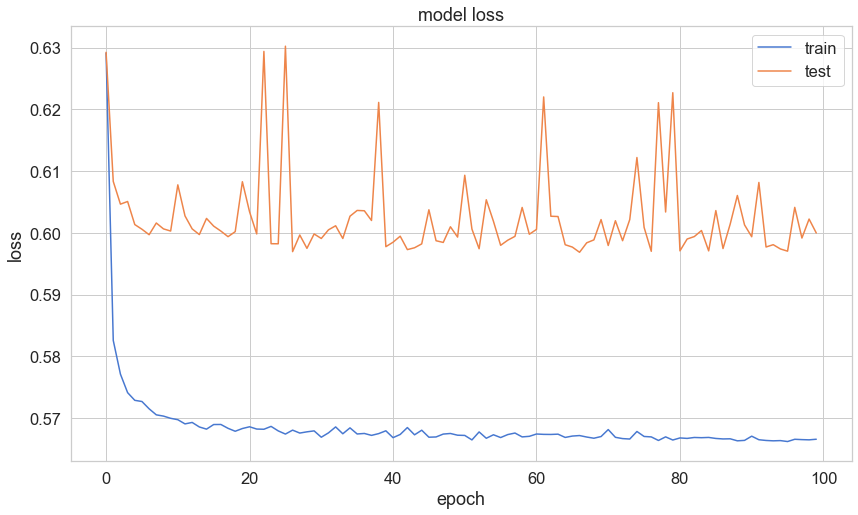

In [20]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [21]:
predictions = autoencoder.predict(X_test)

1781/1781 [==============================] - 2s 1ms/step


In [22]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

In [23]:
error_df.describe()

,reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.595844,0.001720
std,3.162521,0.041443
min,0.021436,0.000000
25%,0.167033,0.000000
50%,0.289010,0.000000
75%,0.486390,0.000000
max,250.585759,1.000000


## Reconstruction error without fraud

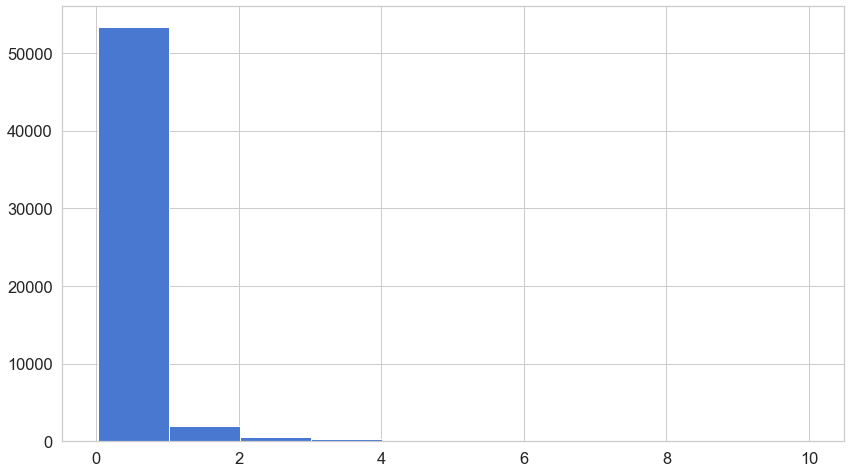

In [24]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

## Reconstruction error with fraud

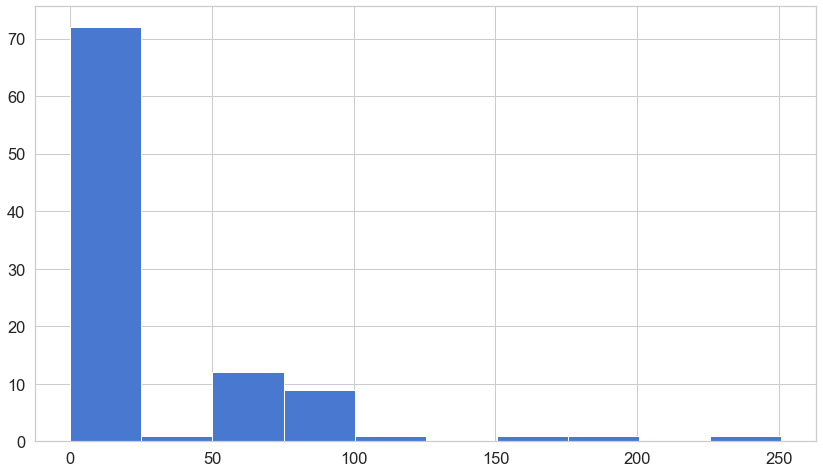

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

ROC curves are very useful tool for understanding the performance of binary classifiers. 
However, our case is a bit out of the ordinary, we have a very imbalanced dataset. Nonetheless, let's have a look at our ROC curve:

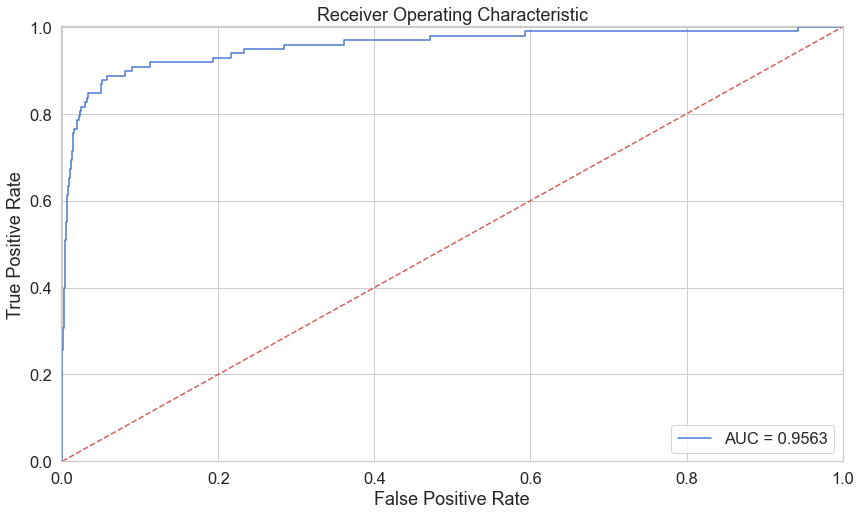

In [26]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

The ROC curve plots the true positive rate versus the false positive rate, over different threshold values. Basically, we want the blue line to be as close as possible to the upper left corner. While our results look pretty good, we have to keep in mind of the nature of our dataset. ROC doesn't look very useful for us. Onward...

## Precision vs recall

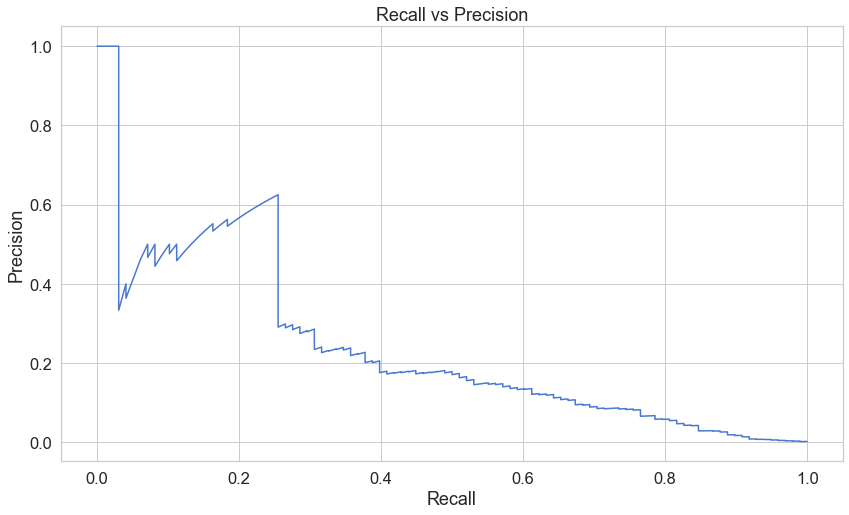

In [27]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

A high area under the curve indicates both strong recall and high accuracy, with high precision corresponding to a low false positive rate and high recall corresponding to a low false negative rate. High scores for both indicate that the classifier is producing accurate results (high precision) and producing the majority of all positive outcomes (high recall).

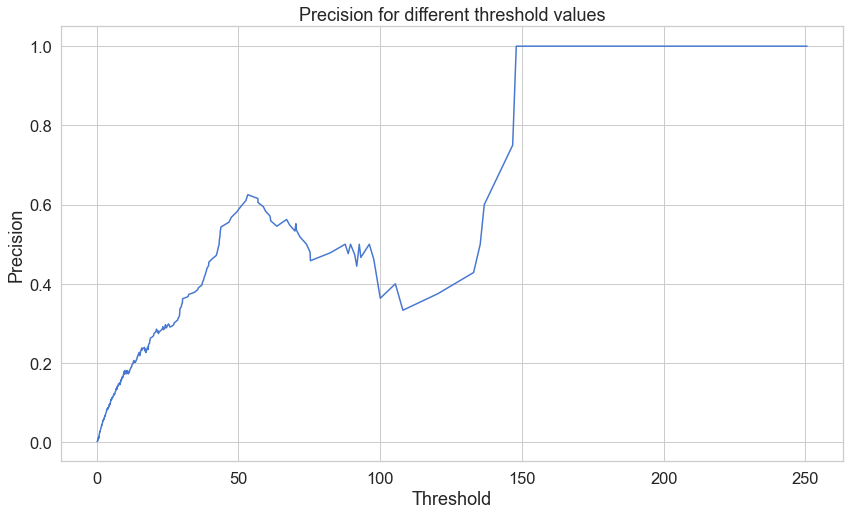

In [28]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

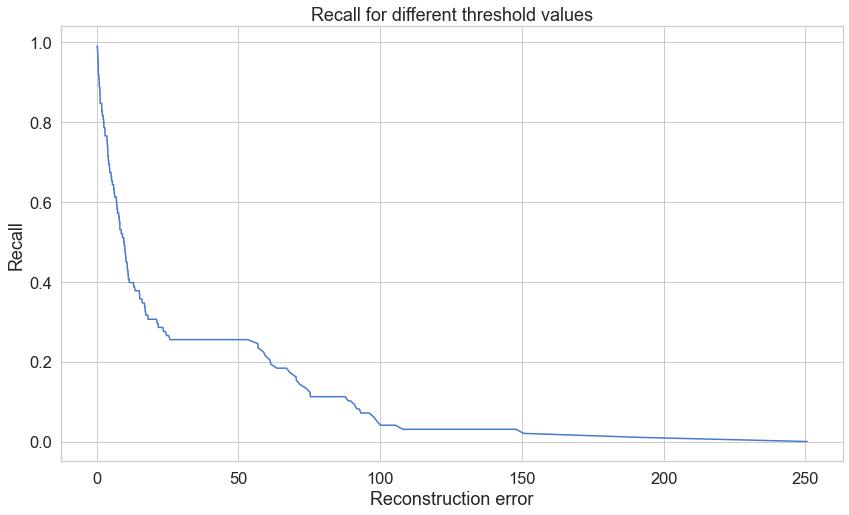

In [29]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

# Prediction

This time, our model is a little different. It has no idea how to forecast new values. But we don't require that. We'll calculate the reconstruction error from the transaction data itself to determine if a new/unseen transaction is normal or fraudulent. If the mistake exceeds a preset threshold, we will classify it as fraud (since our model should have a low error on normal transactions). Let's choose that value:

In [30]:
threshold = 2.9

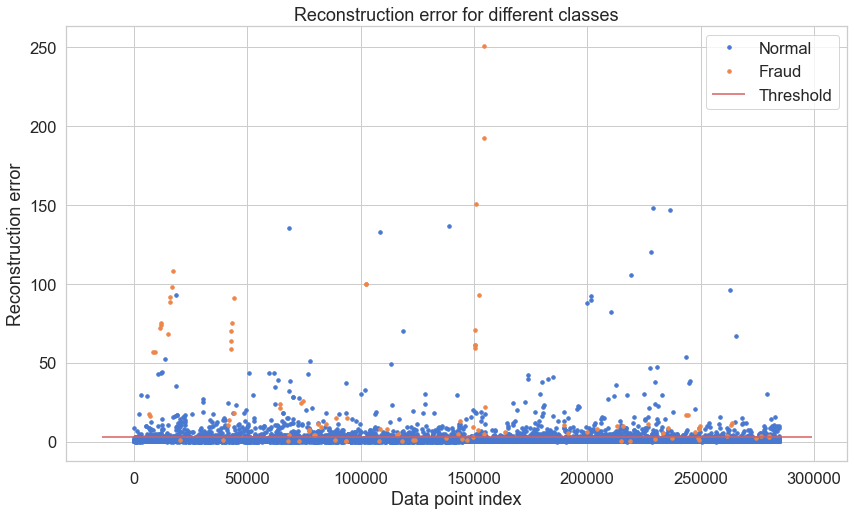

In [31]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

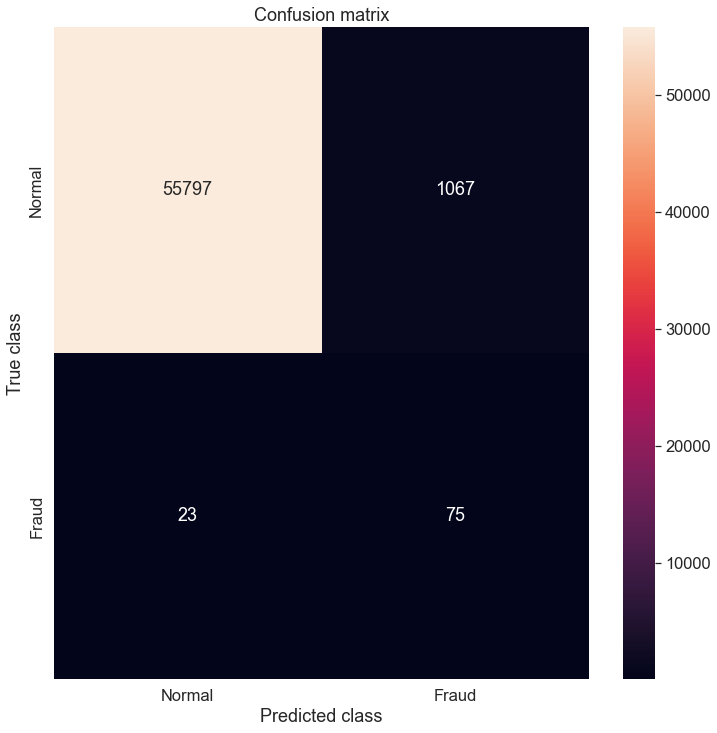

In [32]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()